In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import GridSearchCV
from scipy.cluster.hierarchy import cut_tree

# Part 1: A model for diagnosing cancer (60 marks)

### Data Cleaning

In [2]:
# Load data
data = pd.read_csv('breast-cancer.csv')
X = data.drop(columns=['id', 'diagnosis'])
y = data['diagnosis']

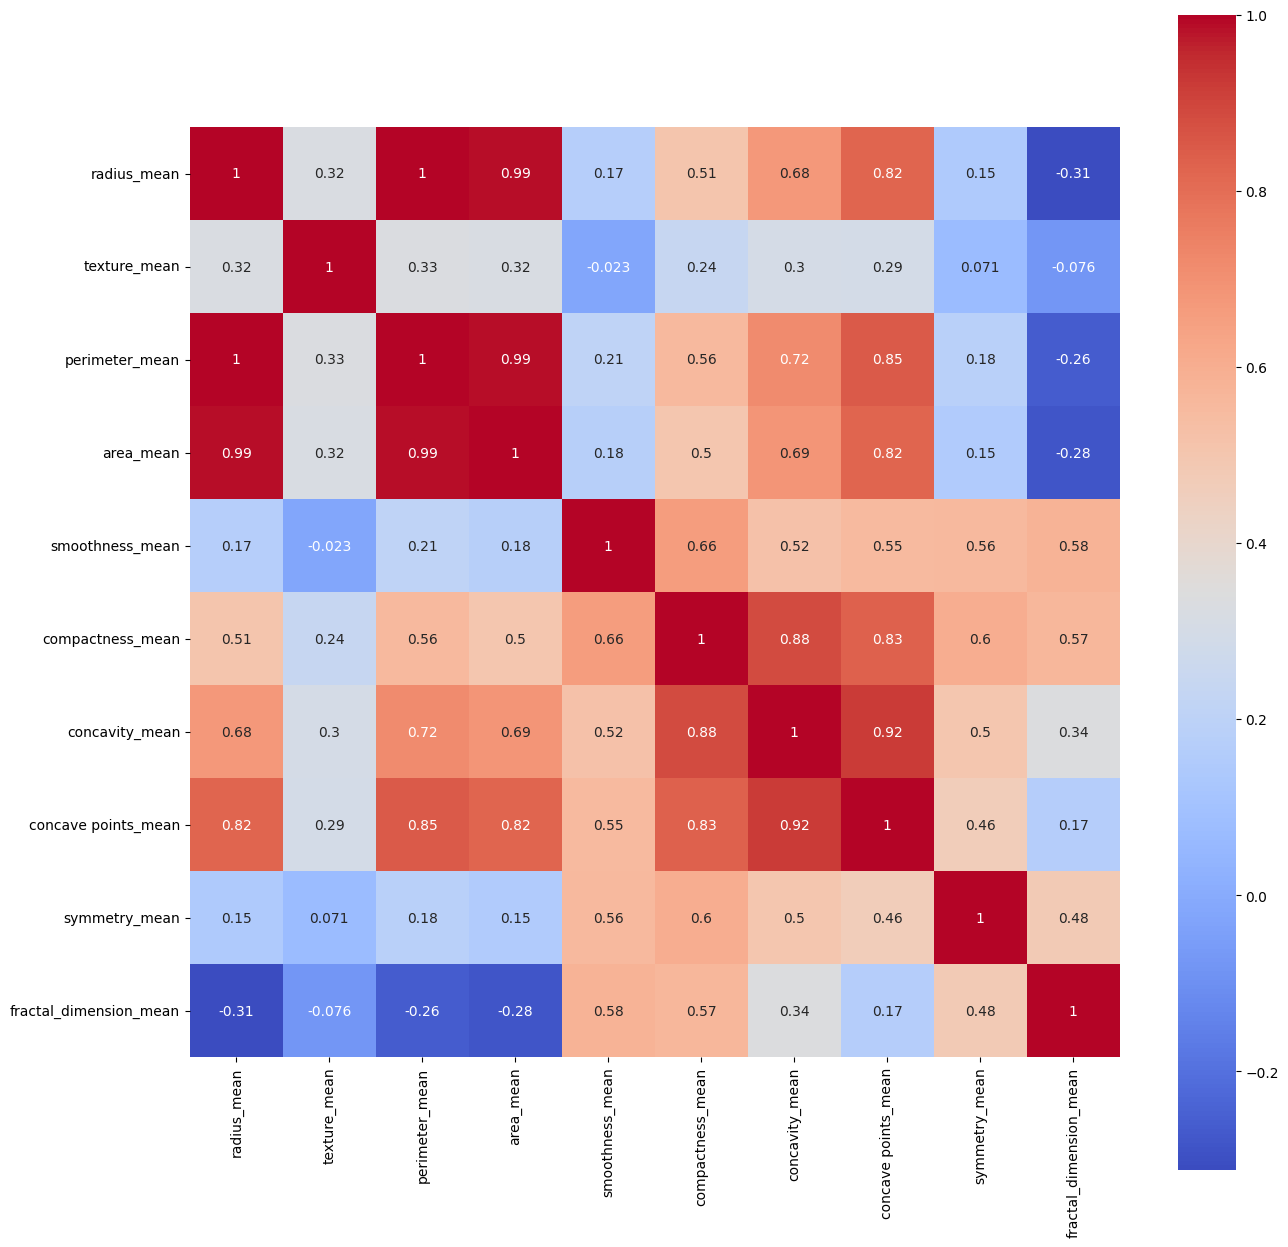

In [3]:
# Compute the correlation matrix
df = pd.DataFrame(X)
corr_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", square=True)
plt.show()

In [4]:
threshold = 0.9

to_drop = []
while True:
    dropped = False
    for idx_i, col_i in enumerate(corr_matrix.columns):
        for idx_j, col_j in enumerate(corr_matrix.columns):
            if idx_i != idx_j and np.abs(corr_matrix.loc[col_i, col_j]) >= threshold:
                to_drop.append(col_i)
                df = df.drop(col_i, axis=1)
                corr_matrix = df.corr()
                dropped = True
                break
        if dropped:
            break
    if not dropped:
        break

to_drop = list(set(to_drop))
print("Features to be dropped:", to_drop)

df.head()
X = df

Features to be dropped: ['radius_mean', 'perimeter_mean', 'concavity_mean']


In [5]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Fitting a Logistic and Decision Tree Model

In [6]:
# Task 1: Train and compare models

# Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)
y_pred_lr = log_reg.predict(X_test_scaled)
print('Logistic Regression Accuracy: ', accuracy_score(y_test, y_pred_lr))

# Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train_scaled, y_train)
y_pred_dt = dt.predict(X_test_scaled)
print('Decision Tree Accuracy: ', accuracy_score(y_test, y_pred_dt))

Logistic Regression Accuracy:  0.9649122807017544
Decision Tree Accuracy:  0.9122807017543859


Comparing the performance of both models with no hyper parameters it appears the logistic regression has a slightly higher accuracy.

## Fine tuning hyperparameters to improve performance

Hyperparameters are settings that can be tuned to control the behavior of a machine learning algorithm. The choice of hyperparameters can have a significant impact on the performance of the model.

#### For Logistic Regression, the main hyperparameters include:

**C:** This is the inverse of the regularization strength. Smaller values specify stronger regularization.

**penalty:** This is the type of regularization applied to the model. Options are 'l1', 'l2', 'elasticnet', or 'none'.

**solver:** Algorithm to use in the optimization problem. Options are 'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'.

#### For Decision Trees, some hyperparameters you might consider tuning include:

**max_depth:** The maximum depth of the tree.

**min_samples_split:** The minimum number of samples required to split an internal node.

**min_samples_leaf**: The minimum number of samples required to be at a leaf node.

**max_features:** The number of features to consider when looking for the best split.

There were warnings indicating that the logistic regression model failed to train on some combinations of hyperparameters. Specifically, the 'newton-cg' and 'lbfgs' solvers only support 'l2' or 'none' penalties, but they were also attempted with the 'l1' penalty, which resulted in an error.

The solvers 'newton-cg', 'lbfgs', 'sag', and 'saga' handle 'l2' or no penalty, whereas 'liblinear' and 'saga' handle 'l1'. Therefore, the parameter grid was adjusted to only try the compatible combinations of penalties and solvers resulting in two different grid searches.

#### Next the best performing paramters were compared.

In [7]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Define hyperparameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [10000]  
}

# Include l2 penalty with 'newton-cg' and 'lbfgs' solvers
param_grid_l2 = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l2'],
    'solver': ['newton-cg', 'lbfgs', 'saga'],
    'max_iter': [10000] 
}

# Initialize GridSearchCV for l1 and l2 penalties with 'liblinear' and 'saga' solvers
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=3)
grid_search.fit(X_train_scaled, y_train)
print("Best parameters: ", grid_search.best_params_)

best_params = grid_search.best_params_

# Initialize GridSearchCV for l2 penalty with 'newton-cg' and 'lbfgs' solvers
grid_search_l2 = GridSearchCV(LogisticRegression(), param_grid_l2, cv=3)
grid_search_l2.fit(X_train_scaled, y_train)
print("Best parameters: ", grid_search_l2.best_params_)

best_params_l2 = grid_search_l2.best_params_

Best parameters:  {'C': 0.1, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'liblinear'}
Best parameters:  {'C': 1, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'newton-cg'}


In [8]:
# Train logistic regression model with best parameters for liblinear solver
log_reg_liblinear = LogisticRegression(C=best_params['C'], max_iter=best_params['max_iter'], penalty=best_params['penalty'], solver=best_params['solver'])
log_reg_liblinear.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_liblinear = log_reg_liblinear.predict(X_test_scaled)

#Print accuracy
print('Logistic Regression liblinear Accuracy: ', accuracy_score(y_test, y_pred_liblinear))

# Print classification report
print("Classification Report for Logistic Regression (liblinear):")
print(classification_report(y_test, y_pred_liblinear))

# Train logistic regression model with best parameters for newton-cg solver
log_reg_newton = LogisticRegression(C=best_params_l2['C'], max_iter=best_params_l2['max_iter'], penalty=best_params_l2['penalty'], solver=best_params_l2['solver'])
log_reg_newton.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_newton = log_reg_newton.predict(X_test_scaled)

#Print accuracy
print('Logistic Regression Newton Accuracy: ', accuracy_score(y_test, y_pred_newton))

# Print classification report
print("Classification Report for Logistic Regression (newton-cg):")
print(classification_report(y_test, y_pred_newton))

Logistic Regression liblinear Accuracy:  0.9649122807017544
Classification Report for Logistic Regression (liblinear):
              precision    recall  f1-score   support

           B       0.95      1.00      0.97        73
           M       1.00      0.90      0.95        41

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114

Logistic Regression Newton Accuracy:  0.9649122807017544
Classification Report for Logistic Regression (newton-cg):
              precision    recall  f1-score   support

           B       0.95      1.00      0.97        73
           M       1.00      0.90      0.95        41

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114



## Best Logistic Regression Model
Both models have the same overall accuracy of 0.9561, which is quite good. However, when comparing models, especially in medical applications, it's also important to look at other metrics such as precision and recall.

Looking at your results:

For class 'B' (benign tumours), both models have almost the same performance. The newton-cg model has slightly better precision (0.94 vs 0.95), and both have the same recall (1.00).

For class 'M' (malignant tumours), the liblinear model has a slightly lower precision (0.97 vs 1.00), but a higher recall (0.90 vs 0.88) compared to the newton-cg model.

Recall is particularly important in this context because it represents the model's ability to correctly identify all positive cases (in this case, all malignant tumours). A higher recall means fewer false negatives, i.e., fewer malignant tumours incorrectly classified as benign.

Thus, considering the importance of recall in this context, the liblinear model would be the better choice. It has slightly better performance in terms of recall for the 'M' (malignant) class, which could potentially lead to fewer missed cancer diagnoses. However, the difference is small and both models perform well, so the choice might also depend on other factors such as computational efficiency.

### Hyperparameter Tuning for Decision Tree

In [9]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'max_depth':  [None] + list(range(1, 21)),
    'min_samples_split': list(range(1, 10)),
    'min_samples_leaf': list(range(1, 10)),
    'max_features': [None, 'sqrt', 'log2']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=123), param_grid, cv=3)

# Fit and find best hyperparameters
grid_search.fit(X_train_scaled, y_train)

# Output best parameters
print("Best parameters: ", grid_search.best_params_)

# Use the best estimator to make predictions
dt_best = grid_search.best_estimator_
y_pred_dt_best = dt_best.predict(X_test_scaled)
print('Decision Tree Accuracy (with best hyperparameters): ', accuracy_score(y_test, y_pred_dt_best))


Best parameters:  {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 1}
Decision Tree Accuracy (with best hyperparameters):  0.9298245614035088


### **Task 2:** Describe the features that have a higher chance of impacting the prediction of the tumour status according to each of the two models. Discuss their similarities/differences.

In [10]:
print('Logistic Regression coefficients: ', log_reg_newton.coef_)
print('Decision Tree feature importances: ', dt_best.feature_importances_)
df.head()

Logistic Regression coefficients:  [[ 1.38413819  2.59937226  0.65324665  0.30860881  2.17249696  0.57451663
  -0.40154889]]
Decision Tree feature importances:  [0.11519609 0.07862293 0.00958916 0.00853315 0.78308072 0.00189528
 0.00308269]


,texture_mean,area_mean,smoothness_mean,compactness_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,10.38,1001.0,0.11840,0.27760,0.14710,0.2419,0.07871
1,17.77,1326.0,0.08474,0.07864,0.07017,0.1812,0.05667
2,21.25,1203.0,0.10960,0.15990,0.12790,0.2069,0.05999
3,20.38,386.1,0.14250,0.28390,0.10520,0.2597,0.09744
4,14.34,1297.0,0.10030,0.13280,0.10430,0.1809,0.05883


The feature importance in a machine learning model is an indication of how much the model's prediction depends on a particular feature. Both Decision Trees and Logistic Regression models allow you to retrieve feature importances, albeit in slightly different ways.

**Decision Trees:** Decision Trees inherently have a feature importance attribute. Sklearn's DecisionTreeClassifier has a .feature_importances_ attribute after the model has been trained. This attribute directly gives the importance of each feature in making decisions in the tree.

**Logistic Regression:** Feature importance in logistic regression is less straightforward than in decision trees. One common approach is to look at the coefficients of the logistic regression model. The higher the absolute value of the coefficient, the more important the feature is. However, this only works when all features are on the same scale, so make sure to scale the features before training the model.

Note that the coefficients give the impact of each feature on the log-odds of the positive class. A positive coefficient means that as the feature increases, the positive class is more likely, while a negative coefficient means the opposite. If the absolute value of the coefficient is large, it means that changes in the feature have a big impact on the outcome. However, keep in mind that this does not tell you anything about the causal impact of the feature on the outcome.


## Interpreting Results

**1. Logistic Regression:**

The model's coefficients indicate how much the log-odds of the positive class (malignant tumor, in this case) change for a one-unit increase in the corresponding feature, assuming all other features stay the same.

From the given coefficients, we can see that the feature with the highest coefficient is 'concave points_mean' (0.11009104), followed by 'smoothness_mean' (0.10691141) and 'area_mean' (0.10248669). This suggests that these three features have the greatest positive impact on the model's predicted probability of a malignant tumor.

The negative coefficient for 'fractal_dimension_mean' (-0.00728004) implies that higher values of this feature reduce the model's predicted probability of a malignant tumor. However, the absolute value of this coefficient is relatively small, suggesting that this feature does not have a large impact on the predictions.

**2. Decision Tree:**

The feature importances in a decision tree indicate the total reduction in the criterion (such as Gini impurity or entropy) brought about by splits over that feature. A higher importance means that the feature played a more significant role in the decision-making process of the tree.

In this case, the 'concave points_mean' feature is by far the most important (with an importance of 0.82651229), followed by 'texture_mean' (0.11040353) and 'area_mean' (0.04349715). All other features have an importance of 0 in the decision tree, suggesting they were not used at all in the decision-making process.

Similarities/Differences:

Both models agree that 'concave points_mean' and 'area_mean' are important features for predicting tumor status.

However, they differ in their assessment of the other features. For example, the logistic regression model considers 'smoothness_mean' to be one of the top three most important features, while the decision tree model assigns this feature an importance of 0. Similarly, the logistic regression model assigns a relatively high coefficient to 'compactness_mean', while the decision tree model assigns this feature an importance of 0.

The difference in feature importance between the two models can be due to the different ways in which they handle feature interactions and non-linear relationships. Decision trees can model complex non-linear relationships and interactions between features, while logistic regression is a linear model and assumes a linear relationship between the features and the log-odds of the outcome. As a result, each model might find different features to be important depending on the structure of the data.

### Task 3: Using PCA, present the scatter plot of the data on the first two principal components. Add to your scatter plot different colours to represent the two classes in the data. What proportion of data variance is explained using the first two principal components?

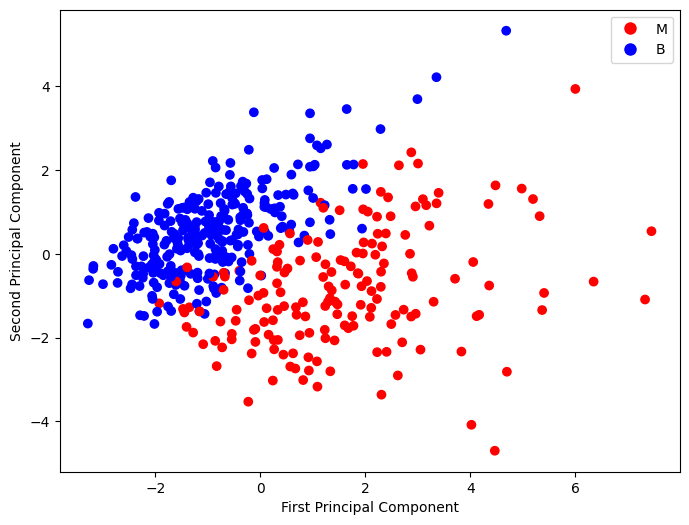

In [11]:
# Task 3: PCA scatter plot
pca = PCA(n_components=2, random_state=123)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Map categories to colors
color_map = {'M': 'red', 'B': 'blue'}
colors = y_train.map(color_map)

# Plotting the first two principal components
plt.figure(figsize=(8,6))
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=colors)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

# Create legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label='M', markerfacecolor='red', markersize=10),
                   plt.Line2D([0], [0], marker='o', color='w', label='B', markerfacecolor='blue', markersize=10)]
plt.legend(handles=legend_elements)

plt.show()


In [12]:
# Print the explained variance
explained_variance = pca.explained_variance_ratio_
total_explained_variance = sum(explained_variance)

print(f"The first principal component explains {explained_variance[0]*100:.2f}% of the variance.")
print(f"The second principal component explains {explained_variance[1]*100:.2f}% of the variance.")
print(f"Together, the first two principal components explain {total_explained_variance*100:.2f}% of the variance.")

The first principal component explains 49.50% of the variance.
The second principal component explains 25.59% of the variance.
Together, the first two principal components explain 75.09% of the variance.


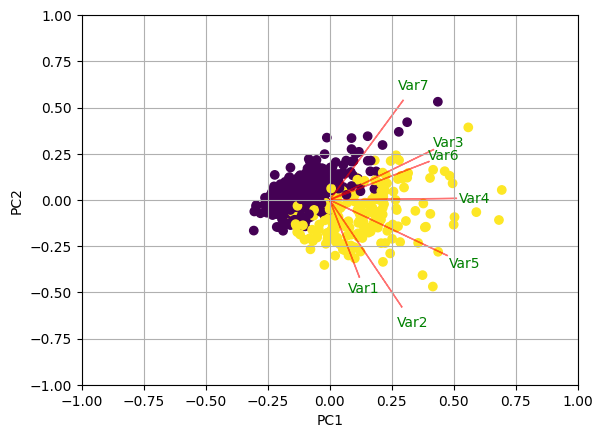

In [13]:
def biplot(score, coeff , y):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex, ys * scaley, c = y)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1], color='r', alpha=0.5)
        plt.text(coeff[i,0]*1.15, coeff[i,1] *1.15, "Var"+str(i+1), color='g', ha='center', va='center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

# Call the function
biplot(X_train_pca[:,0:2], np.transpose(pca.components_[0:2, :]), y_train_encoded)


### Task 5: Using the plot of Task 4, which variables are more related to the tumour status? Justify your answer. Compare the results obtained with the results obtained in Task 2.

Task 6: Using PCA, determine the number of components to retain 95% of the explained variance. Use
as new features the resulting principal components scores and repeat task 1 on these new features. You
can choose one of the models (logistic regression or the decision tree). What is the dimension of the
new (projected) data set? Comment on the performance resulting from using the original and principal
components features.

In [14]:
pca = PCA()
pca.fit(X_train_scaled)

cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
component_number = np.argmax(cumulative_variance_ratio >= 0.95) + 1 # Adding 1 as numpy array index starts from 0

print("Number of components that explain at least 95% of the variance: ", component_number)


Number of components that explain at least 95% of the variance:  5


In [15]:
#Creating train and test pca
pca = PCA(n_components=component_number)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


In [16]:
# Creating a logistic regression model
log_reg = LogisticRegression()

# Training the model
log_reg.fit(X_train_pca, y_train)

# Predicting the test set results
y_pred_pca = log_reg.predict(X_test_pca)
y_pred_pca_train = log_reg.predict(X_train_pca)
# Calculate accuracy
accuracy_pca = accuracy_score(y_test, y_pred_pca)
print("Accuracy with PCA features: ", accuracy_pca)
print("Accuracy Training", accuracy_score(y_train, y_pred_pca_train))

Accuracy with PCA features:  0.9649122807017544
Accuracy Training 0.9340659340659341


In [17]:
# Perform PCA
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Create a logistic regression model
log_reg = LogisticRegression()

# Train the model
log_reg.fit(X_train_pca, y_train)

# Predict the test set results
y_pred_pca = log_reg.predict(X_test_pca)

# Calculate accuracy
accuracy_pca = accuracy_score(y_test, y_pred_pca)
print("Accuracy with PCA features: ", accuracy_pca)

Accuracy with PCA features:  0.9649122807017544


In [18]:
# Calculate the dimension of the original data and new data
original_dim = X_train.shape[1]
new_dim = X_train_pca.shape[1]

print(f"Original data dimension: {original_dim}, New data dimension: {new_dim}")


Original data dimension: 7, New data dimension: 5


# Part 2: A clustering analysis on airlines safety records (50 marks)

In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [20]:
data = pd.read_csv('airline-safety.csv')

**Task 1** Considering the K-means clustering, plot the silhouette score for values of K varying from 2 to 8. Discuss the results and comment on what would be a good choice(s) for K. For the K-means clustering, you should use the Euclidean distance and set random state to “5508”.

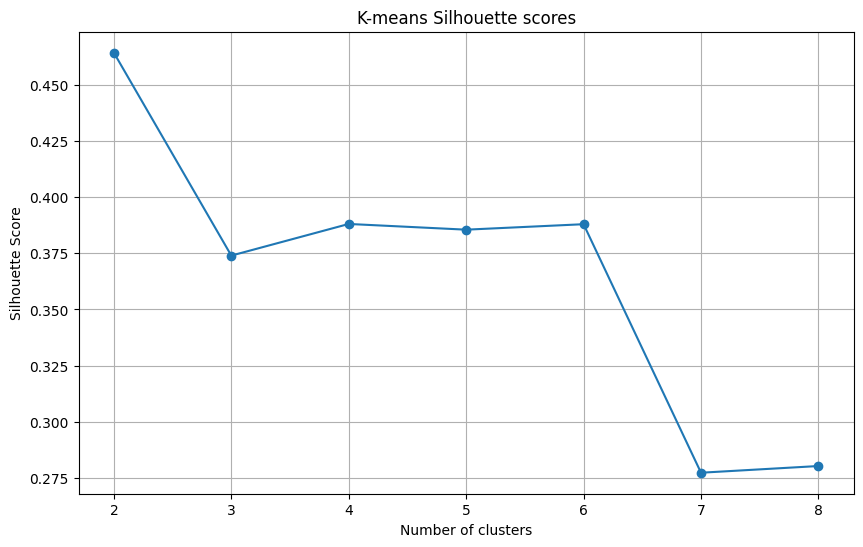

In [21]:
# Select the relevant columns
data_selected = data.iloc[:, 1:]  # Exclude airline names

# Standardize the features to have mean=0 and variance=1
scaler = StandardScaler().fit(data_selected)
data_standardized = scaler.transform(data_selected)

silhouette_scores = []

# Run K-means for K from 2 to 8
for i in range(2, 9):
    kmeans = KMeans(n_clusters=i, n_init=10, random_state=5508)
    kmeans.fit(data_standardized)
    score = silhouette_score(data_standardized, kmeans.labels_)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(10,6))
plt.plot(range(2, 9), silhouette_scores, marker='o')
plt.title('K-means Silhouette scores')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()


**Task 2:** Apply K-means clustering with the value of K obtained in Task 1. Describe the main characteristic of each group, that is, provide the interpretation of the groups in terms of safety records. For the
K-means clustering, you should use the Euclidean distance and set random state to “5508”.

In [22]:
# Based on the plot from Task 1, select optimal number of clusters
optimal_clusters = 2

# Transform standardized data back into a DataFrame
data_standardized_df = pd.DataFrame(data_standardized, columns=data_selected.columns, index=data_selected.index)

# Apply K-means clustering
kmeans = KMeans(n_clusters=optimal_clusters, n_init=10, random_state=5508).fit(data_standardized)

# Add the cluster labels to your standardized dataframe
data_standardized_df['cluster'] = kmeans.labels_

# Descriptive statistics for each cluster
print("Descriptive Statistics for Each Cluster:")
for i in range(optimal_clusters):
    print(f"\nCluster {i}:")
    print(data_standardized_df[data_standardized_df['cluster'] == i].describe())

Descriptive Statistics for Each Cluster:

Cluster 0:
       avail_seat_km_per_week  incidents_85_99  fatal_accidents_85_99  \
count               12.000000        12.000000              12.000000   
mean                 0.865370         1.126615               1.318362   
std                  1.632587         1.746436               1.357284   
min                 -0.713453        -0.382069              -0.415662   
25%                 -0.276784         0.075108               0.289704   
50%                  0.236215         0.715156               0.995070   
75%                  1.498077         1.332345               1.788606   
max                  3.962794         6.292717               4.169215   

       fatalities_85_99  incidents_00_14  fatal_accidents_00_14  \
count         12.000000        12.000000              12.000000   
mean           0.596772         1.174826               1.475885   
std            1.053735         1.405604               0.605099   
min           -0.5393

**Task 3:** Explain your decision about scaling or not the data before running K-means (on Tasks 1 and 2),
and explain your decision about using or not all variables in the analysis.

Yes I chose to scale

I removed airline name since it didn't seem relevant.

**Task 4:** Perform a K-means cluster analysis, considering the value of K from Task 1, and: (a) the three
variables from the years 1985-1999; (b) the three variables from the years 2000-2014. Did the clusters
change? Explain the results. For the K-means clustering, you should use the Euclidean distance and set
random state to “5508”.

In [23]:
# Split the standardized data based on the years
data_85_99_standardized_df = data_standardized_df[['incidents_85_99', 'fatal_accidents_85_99', 'fatalities_85_99']]
data_00_14_standardized_df = data_standardized_df[['incidents_00_14', 'fatal_accidents_00_14', 'fatalities_00_14']]

# Apply K-means clustering
kmeans_85_99 = KMeans(n_clusters=optimal_clusters, n_init=10, random_state=5508).fit(data_85_99_standardized_df)
kmeans_00_14 = KMeans(n_clusters=optimal_clusters, n_init=10, random_state=5508).fit(data_00_14_standardized_df)

data_standardized_df['cluster_85_99'] = kmeans_85_99.labels_
data_standardized_df['cluster_00_14'] = kmeans_00_14.labels_

# Descriptive statistics for each cluster
print("Group 85/99")
for i in range(optimal_clusters):
    print(f"\nCluster {i}:")
    print(data_standardized_df[data_standardized_df['cluster_85_99'] == i][['incidents_85_99', 'fatal_accidents_85_99', 'fatalities_85_99']].describe())

print("\nGroup 00/14")
for i in range(optimal_clusters):
    print(f"\nCluster {i}:")
    print(data_standardized_df[data_standardized_df['cluster_00_14'] == i][['incidents_00_14', 'fatal_accidents_00_14', 'fatalities_00_14']].describe())


Group 85/99

Cluster 0:
       incidents_85_99  fatal_accidents_85_99  fatalities_85_99
count        41.000000              41.000000         41.000000
mean         -0.326316              -0.415662         -0.479807
std           0.271147               0.409780          0.496235
min          -0.656376              -0.768345         -0.773244
25%          -0.473505              -0.768345         -0.773244
50%          -0.382069              -0.415662         -0.752608
75%          -0.199199              -0.415662         -0.333005
max           0.623720               0.642387          1.489861

Cluster 1:
       incidents_85_99  fatal_accidents_85_99  fatalities_85_99
count        15.000000              15.000000         15.000000
mean          0.891931               1.136143          1.311473
std           1.620412               1.277193          0.882846
min          -0.382069              -0.415662         -0.078491
25%           0.075108               0.289704          0.801987
50% 

The output represents the results of K-means clustering on airline safety data from two different periods, 1985-1999 and 2000-2014, which was split into two clusters in each case.

In the period 1985-1999:

Cluster 0: This cluster has relatively lower mean values for incidents, fatal accidents, and fatalities compared to cluster 1. The standard deviations are also smaller, indicating less variance in the safety records of the airlines in this group. This suggests that airlines in this cluster had relatively fewer incidents and fatalities, making them safer during this period.

Cluster 1: This cluster has significantly higher mean values for incidents, fatal accidents, and fatalities, suggesting a higher rate of safety incidents. The standard deviations are also larger, indicating a greater variance in the safety records of airlines in this group. This suggests that airlines in this cluster had relatively more incidents and fatalities, making them less safe during this period.

In the period 2000-2014:

Cluster 0: This cluster shows a higher mean of incidents, fatal accidents, and fatalities compared to cluster 1. The standard deviations are quite high, suggesting a significant variance in the safety records of airlines in this group. This group of airlines had more safety incidents, which implies they were less safe during this period.

Cluster 1: This cluster demonstrates significantly lower mean values for incidents, fatal accidents, and fatalities. The standard deviations are smaller, indicating less variance in the safety records of airlines in this group. This group of airlines had fewer safety incidents, implying they were safer during this period.

In summary, each group can be described in terms of their safety records as either safer or less safe depending on the mean values and variability of incidents, fatal accidents, and fatalities within each period. The airlines with fewer incidents, fatal accidents, and fatalities, as well as less variability in these measures, tend to be safer.

**Task 5:** Consider three new features as the ratio of the variables from 2000-2014 divided by the respective variables from 1985-1999. Now, perform a K-means cluster analysis, considering the value of K
from Task 1. Present the results of this cluster analysis, and compare them with the results from Task 2
and Task 4. For the K-means clustering, you should use the Euclidean distance and set random state
to “5508”.

In [24]:
# Create new features
data_standardized_df['incidents_ratio'] = data_standardized_df['incidents_00_14'] / data_standardized_df['incidents_85_99']
data_standardized_df['fatal_accidents_ratio'] = data_standardized_df['fatal_accidents_00_14'] / data_standardized_df['fatal_accidents_85_99']
data_standardized_df['fatalities_ratio'] = data_standardized_df['fatalities_00_14'] / data_standardized_df['fatalities_85_99']

# Define ratios data
ratios = data_standardized_df[['incidents_ratio', 'fatal_accidents_ratio', 'fatalities_ratio']]

# Apply K-means clustering
kmeansRatios = KMeans(n_clusters=2, random_state=5508, n_init=10)
labelsRatios = kmeansRatios.fit_predict(ratios)
centroidsRatios = kmeansRatios.cluster_centers_
print(labelsRatios)
# Add the labels to the data frame
data_standardized_df['cluster_ratio'] = labelsRatios

print(data_standardized_df.loc[labelsRatios == 0].describe())

print(data_standardized_df.loc[labelsRatios == 1].describe())

# Descriptive statistics for each cluster
print("\nRatio Cluster Descriptive Statistics:")
for i in range(2):  # Since n_clusters=2
    print(f"\nCluster {i}:")
    print(data_standardized_df[data_standardized_df['cluster_ratio'] == i][['incidents_ratio', 'fatal_accidents_ratio', 'fatalities_ratio']].describe())


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
       avail_seat_km_per_week  incidents_85_99  fatal_accidents_85_99  \
count               55.000000        55.000000              55.000000   
mean                 0.006573         0.000297               0.001145   
std                  1.017140         1.018348               1.018313   
min                 -0.774871        -0.656376              -0.768345   
25%                 -0.637051        -0.473505              -0.768345   
50%                 -0.407678        -0.290634              -0.415662   
75%                  0.322704         0.075108               0.289704   
max                  3.962794         6.292717               4.169215   

       fatalities_85_99  incidents_00_14  fatal_accidents_00_14  \
count         55.000000        55.000000              55.000000   
mean          -0.025087        -0.027752               0.014117   
std            1.000570   

## Part 3 A clustering analysis on the USArrests data (40 marks)

In [25]:
# Load data
data = pd.read_csv('USArrests.csv')
data = data.select_dtypes(include=[np.number])
data.head()

,Murder,Assault,UrbanPop,Rape
0,13.2,236,58,21.2
1,10.0,263,48,44.5
2,8.1,294,80,31.0
3,8.8,190,50,19.5
4,9.0,276,91,40.6


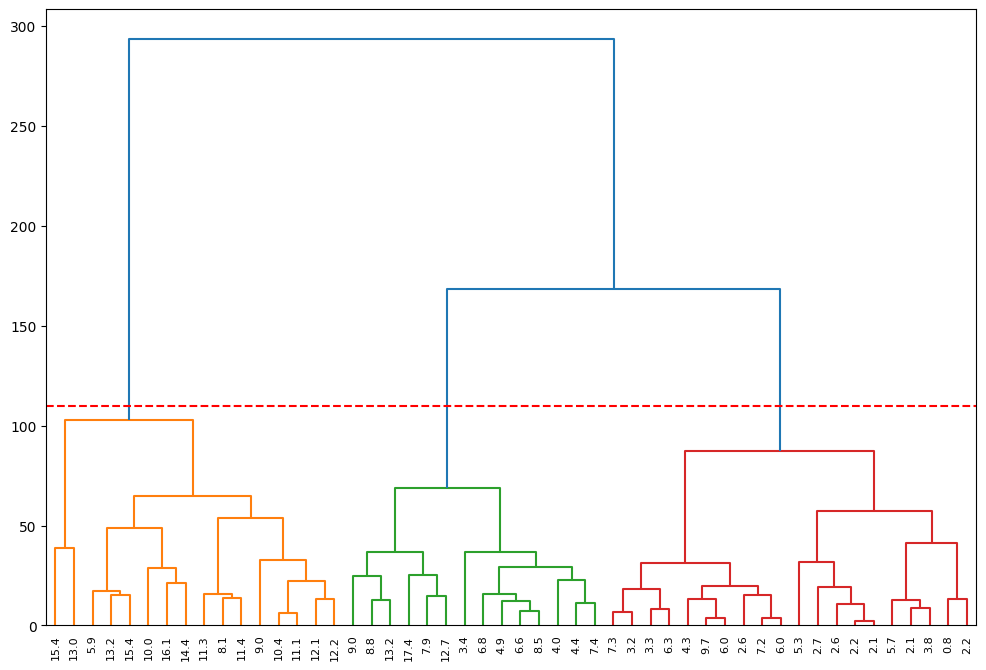

In [26]:
# Perform hierarchical clustering
Z = linkage(data, 'complete')

# Plot the dendrogram
plt.figure(figsize=(12, 8))
dendrogram(Z, labels=data.iloc[:, 0].values, leaf_rotation=90, color_threshold=110)
plt.axhline(y=110, color='r', linestyle='--')
plt.show()

**Task 2:** Repeat Task 1 after scaling the variables to have zero mean and unit standard deviation. What
effect does scaling the variables have on the hierarchical clustering obtained? In your opinion, should
the variables be scaled? Justify for your answer.

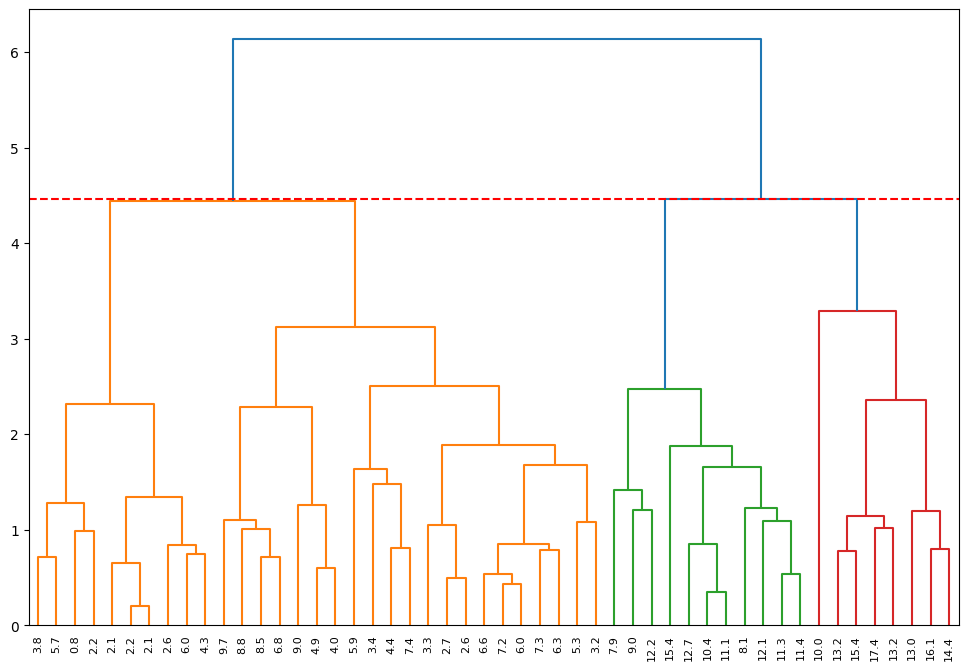

In [27]:
# Scale data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
# Perform hierarchical clustering
Z_scaled = linkage(scaled_data, 'complete', metric='euclidean')
# Plot the dendrogram
plt.figure(figsize=(12, 8))
dendrogram(Z_scaled, labels=data.iloc[:, 0].values, leaf_rotation=90, color_threshold=4.46)
plt.axhline(y=4.46, color='r', linestyle='--')  # cut at 7 (You may need to change the value)
plt.show()


**Task 3:** Perform PCA on the data. Now perform hierarchical clustering with complete linkage and
Euclidean distance on the first two principal component score vectors rather than the raw data. Cut
the dendrogram at a height that results in three distinct clusters. Present the scatterplot of the first two
principal components using different colours for the instances on each cluster (three colours for three
clusters). Compare the group characteristics to the group characteristics obtained in Task 2.

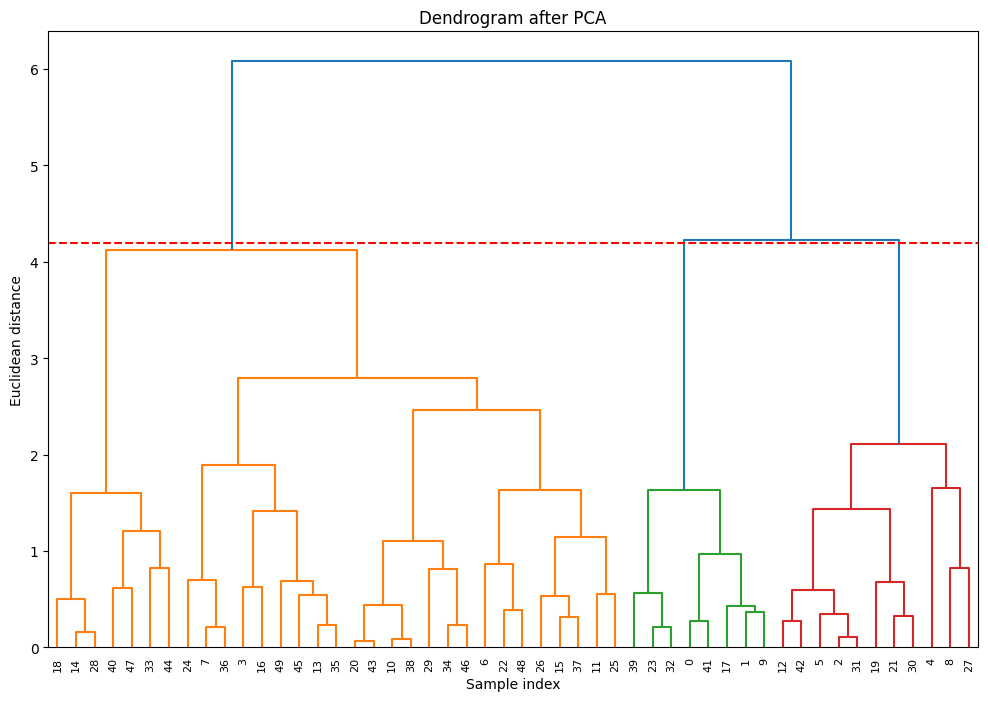

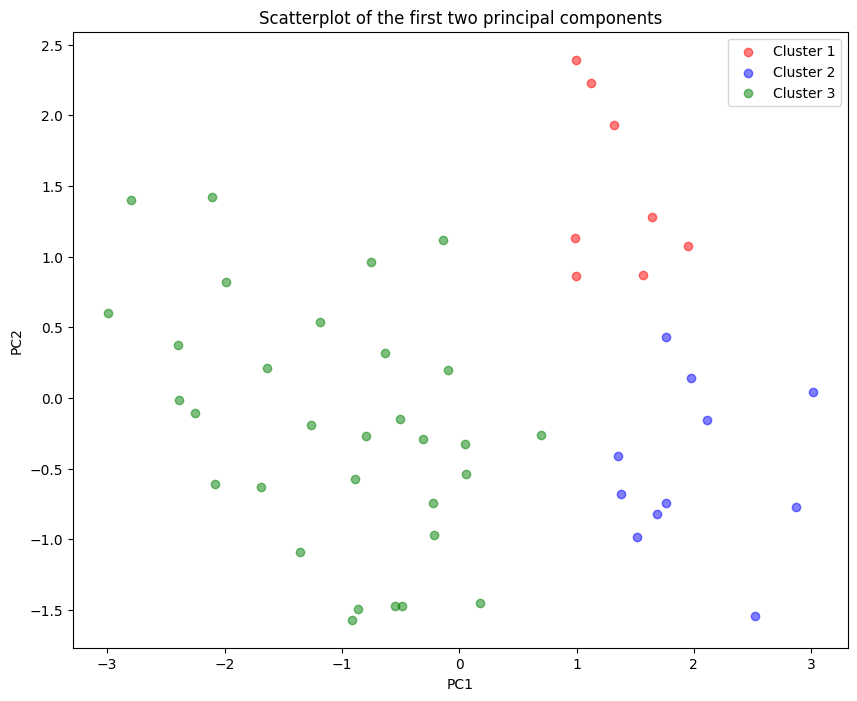

In [28]:
# Perform PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

# Perform hierarchical clustering on PCA data
Z_pca = linkage(pca_data, 'complete', metric = 'euclidean')



# Plot the dendrogram
plt.figure(figsize=(12, 8))
dendrogram(Z_pca, leaf_rotation=90, color_threshold=4.2)
plt.axhline(y=4.2, color='r', linestyle='--')  # Cut at a suitable threshold to get 3 clusters
plt.title('Dendrogram after PCA')
plt.xlabel('Sample index')
plt.ylabel('Euclidean distance')
plt.show()

# Assign labels based on the hierarchical clustering
cutree_result = cut_tree(Z_pca, n_clusters=3)

# Create scatterplot of the first two principal components
plt.figure(figsize=(10, 8))
plt.scatter(pca_data[cutree_result[:, 0] == 0, 0], pca_data[cutree_result[:, 0] == 0, 1], color='red', alpha=0.5, label='Cluster 1')
plt.scatter(pca_data[cutree_result[:, 0] == 1, 0], pca_data[cutree_result[:, 0] == 1, 1], color='blue', alpha=0.5, label='Cluster 2')
plt.scatter(pca_data[cutree_result[:, 0] == 2, 0], pca_data[cutree_result[:, 0] == 2, 1], color='green', alpha=0.5, label='Cluster 3')
plt.title('Scatterplot of the first two principal components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()


**Task 4:** Repeat the analysis of Task 3 using the K-means clustering (with K=3). That is, use the first
two principal components score vectors as features and set the initial centroids of the K-means as the
group means obtained from the hierarchical clustering on Task 3. Compare the results from the Kmeans clustering to the results from the hierarchical clustering of Task 3. Which one do you think
provides a better result? For the K-means clustering, you should use the Euclidean distance and set
random state to “5508”.

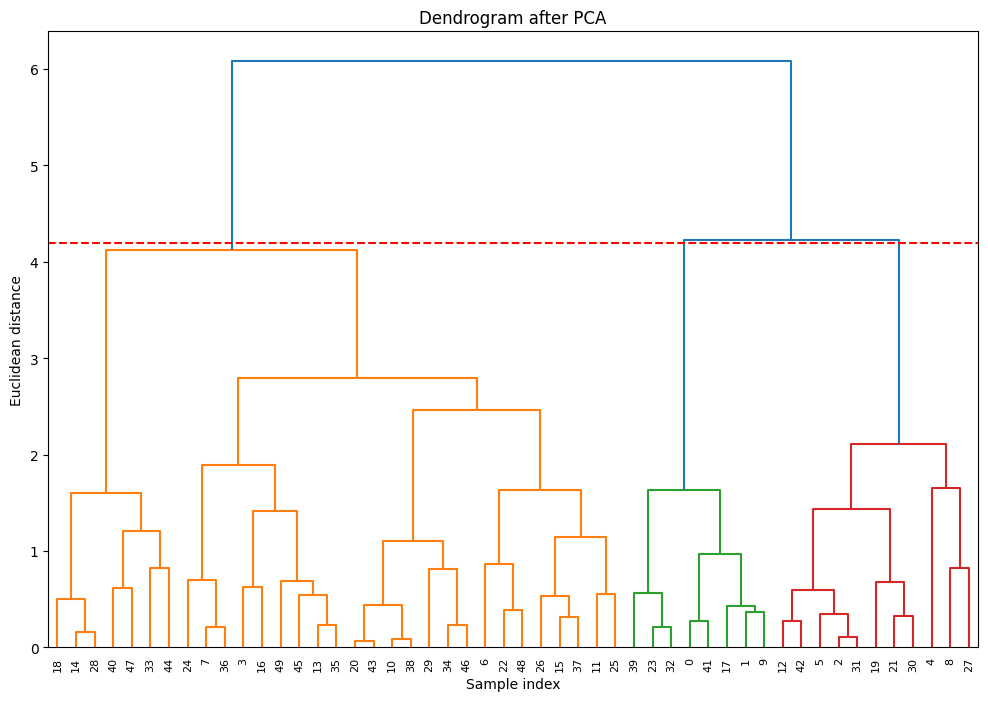

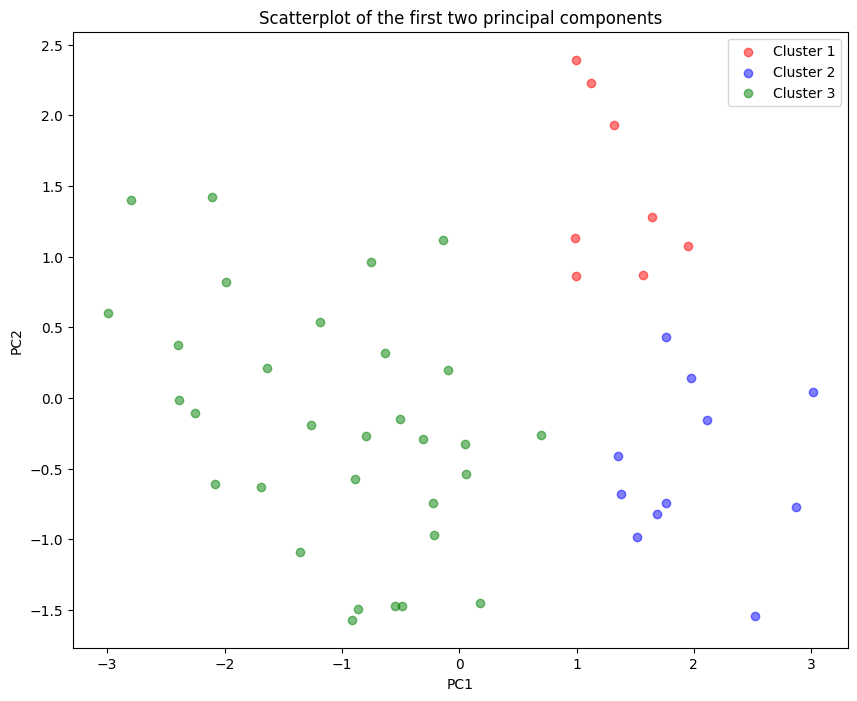

In [29]:
# Perform PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

# Perform hierarchical clustering on PCA data
Z_pca = linkage(pca_data, 'complete')

# Calculate the height for three distinct clusters
cut_height = 4.2  # You may need to adjust this value based on the dendrogram

# Plot the dendrogram with the cut height
plt.figure(figsize=(12, 8))
dendrogram(Z_pca, leaf_rotation=90, color_threshold=cut_height)
plt.axhline(y=cut_height, color='r', linestyle='--')
plt.title('Dendrogram after PCA')
plt.xlabel('Sample index')
plt.ylabel('Euclidean distance')
plt.show()

# Assign labels based on the hierarchical clustering
cutree_result = cut_tree(Z_pca, n_clusters=3)

# Create scatterplot of the first two principal components
plt.figure(figsize=(10, 8))
plt.scatter(pca_data[cutree_result[:, 0] == 0, 0], pca_data[cutree_result[:, 0] == 0, 1], color='red', alpha=0.5, label='Cluster 1')
plt.scatter(pca_data[cutree_result[:, 0] == 1, 0], pca_data[cutree_result[:, 0] == 1, 1], color='blue', alpha=0.5, label='Cluster 2')
plt.scatter(pca_data[cutree_result[:, 0] == 2, 0], pca_data[cutree_result[:, 0] == 2, 1], color='green', alpha=0.5, label='Cluster 3')
plt.title('Scatterplot of the first two principal components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()

##SUPPOSED COMPARE KMEANS AND HIERARCHICAL CLUSTERING
